### Feedfoward Network from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

### I. Inicializamos los datos

In [2]:
data = np.array([[0,0,0],[1,0,1],[0,1,1],[1,1,0]])
data = np.repeat(data, 20, 0)
np.random.shuffle(data)


X = data[:,0:2]
Y = data[:,2:3].T[0]

### II. Graficamos los datos

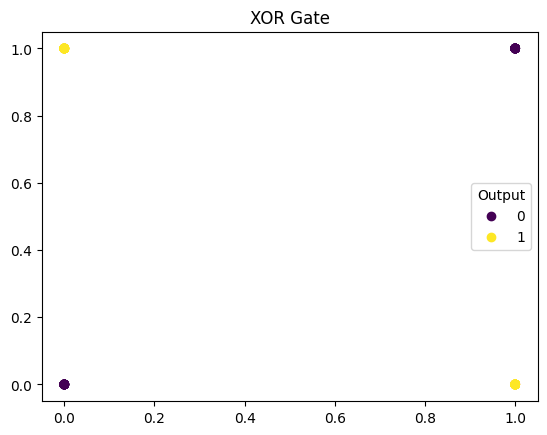

In [3]:

fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("XOR Gate")
scatter = ax.scatter(X[:,0], X[:,1], c=Y)
ax.legend(scatter.legend_elements()[0], ['0','1'], title = "Output")

### III. Implementamos la Red feedfoward

In [4]:
class ActivationFunction:
    f = None
    df = None

    def __init__(self, f, df):
        self.f = f
        self.df = df

    def activate(self,x):
        return self.f(x)

    def derivative(self,x):
        return self.df(x)


# bias se considerara como w0

class FeedFowardNN:

    W = {
        'hidden' : None,
        'output' : None,
    }
    B = {
        'hidden' : None,
        'output' : None,
    }
    f_activation: ActivationFunction = None 

    def __init__(self, input_shape, n_hidden, n_output, activation = 'sigmoid'):
        # Es importante inicializar valores mayores que 1 en este problema
        self.W['hidden'] = 2 * np.random.random(size=(n_hidden, input_shape)) - 1
        self.W['output'] = 2 * np.random.random(size=(n_hidden,n_output)) - 1
        
        self.B['hidden'] = 2 * np.random.random(size=(n_output,n_hidden)) - 1
        self.B['output'] = 2 * np.random.random(size=(1,1)) - 1

        self.f_activation = self.__activation_parser(activation)
    def __activation_parser(self, activation):
        match(activation):
            # Función de activación para realizar la regresión lineal
            case "identity":
                func = lambda x : 1 * x
                d_func = lambda x : x * 1
            # Función de activación para realizar la clasificación
            case "binary_step":
                func = lambda x : 1 if (x > 0) else 0
                d_func = lambda x : x * 1
            case "sigmoid": # aka soft step o logistic
                func = lambda x : 1 / (1 + np.exp(-x)) 
                d_func = lambda y : y * (1 - y)
            case _:
                raise Exception(f'activation must be identity or conditional, given {activation}')
        return ActivationFunction(func, d_func)
    
    def __calculate_loss_squared(self, y_pred, y):
        return (y - y_pred)**2
    
    def get_weights(self):
        return (self.W, self.B)

    # Calcula la propagación hacia adelante
    def __feedfoward_prop(self, X):
        # Calculamos la regresión lineal, multiplicando los datos de entrada
        # por los pesos correspondientes y aplicamos la funcion de activacion
        hidden_output =  self.f_activation.activate(np.dot(X, self.W['hidden'].T) + self.B['hidden'])
        output =  self.f_activation.activate(np.dot(hidden_output, self.W['output']) + self.B['output'])
        return hidden_output, output

    def __backward_prop(self, X, Y, output, hidden_output):
        # Se obtiene la derivada del error con respecto a NetO, para ello se aplico la regla de la cadena
        # mientras mas cercano sea el valor predicho del esperado, menos correciones se hacen en los pesos
        dEdNetO = (output - Y) * self.f_activation.derivative(output)
        # Es calculado la derivada del error con respecto a cada peso de la neurona de salida
        # de manera que se obtiene una matriz 3x1 con las correciones en los pesos de la dicha capa
        dEdWo = (hidden_output * dEdNetO).T
        dEdbo = dEdNetO
        # Las correciones de los pesos de las neuronas escondidas se calcula la razon de cambio del error con respecto
        # a Neth 
        dEdNeth = self.W['output'] * dEdNetO * self.f_activation.derivative(hidden_output).T
        # Se calcula la correciones de los pesos, obteniendo la derivada con respecto a los pesos
        # de la neurona de salida
        dEdWh = dEdNeth * X
        dEdbh = dEdNeth.T
        return dEdWo, dEdWh, dEdbo, dEdbh
    
    def correct_parameters(self, alpha, dEdWo, dEdWh, dEdbo, dEdbh):
        # Se realizan las correciones para cada peso
        self.W['hidden'] -= alpha * dEdWh
        self.B['hidden'] -= alpha * dEdbh
        self.W['output'] -= alpha * dEdWo
        self.B['output'] -= alpha * dEdbo

    def fit(self, X, Y, epochs = 1, alpha = 0.01, verbose = True):
        if ( not isinstance(X, np.ndarray) or not isinstance(Y, np.ndarray)):
            raise Exception(f'X and Y must be a numpy array, given {type(X)} {type(Y)}')
        history = np.zeros(epochs)
        for epoch in range(epochs):
            y_preds = np.zeros(X.shape[0])
           
            for i, sample in enumerate(X):
                hidden_output, output = self.__feedfoward_prop(sample)
                dEdWo, dEdWh, dEdbo, dEdbh = self.__backward_prop(sample, Y[i], output, hidden_output)
                self.correct_parameters(alpha, dEdWo, dEdWh, dEdbo, dEdbh) 
                y_preds[i] = output
           
            loss =  0.5* np.sum((Y - y_preds)**2) 
            if ( verbose ):
                print(f"Epoch {epoch + 1}/{epochs} loss: {loss}")
            history[epoch] = loss
        return history

    def predict(self, X):
        if (not isinstance(X, np.ndarray)):
            raise Exception(f'X must be a numpy array, given {type(X)}')
        y_pred = np.zeros(X.shape[0])
        # Para las predicciones se calcula la propagación hacia delante de
        # cada dato
        for i, row in enumerate(X):
            _, output = self.__feedfoward_prop(row)
            y_pred[i] = np.round(output)
        return y_pred

In [5]:
model = FeedFowardNN(2, 2, 1)
history = model.fit(X,Y, 500, 3.8, True)


Epoch 1/500 loss: 12.140300700798717
Epoch 2/500 loss: 11.747553887752233
Epoch 3/500 loss: 11.518865514272205
Epoch 4/500 loss: 11.425056537218929
Epoch 5/500 loss: 11.297506789904656
Epoch 6/500 loss: 10.849358164669827
Epoch 7/500 loss: 9.376149693936448
Epoch 8/500 loss: 8.135227083094263
Epoch 9/500 loss: 7.750768620426713
Epoch 10/500 loss: 7.56062283213543
Epoch 11/500 loss: 7.336067514247221
Epoch 12/500 loss: 6.909197797847544
Epoch 13/500 loss: 6.423787833581606
Epoch 14/500 loss: 5.994303968119125
Epoch 15/500 loss: 4.2233686812639935
Epoch 16/500 loss: 1.2642213002091442
Epoch 17/500 loss: 0.5105857942940941
Epoch 18/500 loss: 0.31083625864037423
Epoch 19/500 loss: 0.2215692136752142
Epoch 20/500 loss: 0.1713700632358819
Epoch 21/500 loss: 0.13935810636419685
Epoch 22/500 loss: 0.11722891066404605
Epoch 23/500 loss: 0.10104680439921396
Epoch 24/500 loss: 0.0887135884234843
Epoch 25/500 loss: 0.07901091999301618
Epoch 26/500 loss: 0.07118388472593644
Epoch 27/500 loss: 0.064

Text(0, 0.5, 'Loss')

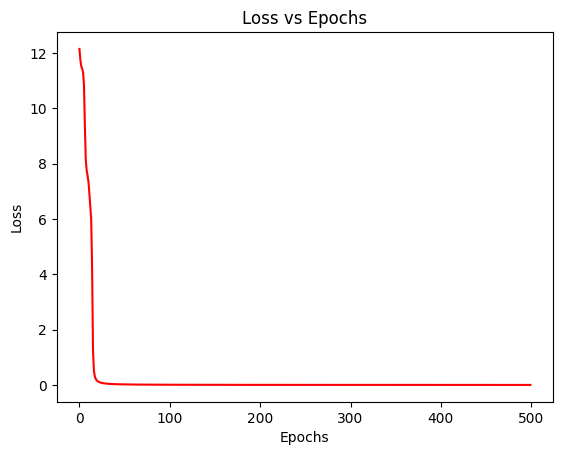

In [6]:
plt.title('Loss vs Epochs')
plt.plot(history, color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [7]:
print(model.predict(X))

[1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1.]


### Implementación con keras

In [8]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=[2], activation = tf.nn.sigmoid),
    tf.keras.layers.Dense(1, activation =  tf.nn.sigmoid)
])
keras_model.compile(
    optimizer=tf.optimizers.SGD(2.5),
    loss='mean_squared_error',
)
history_keras_model = keras_model.fit(X,Y, epochs=500, verbose=False)


Text(0.5, 0, 'Loss')

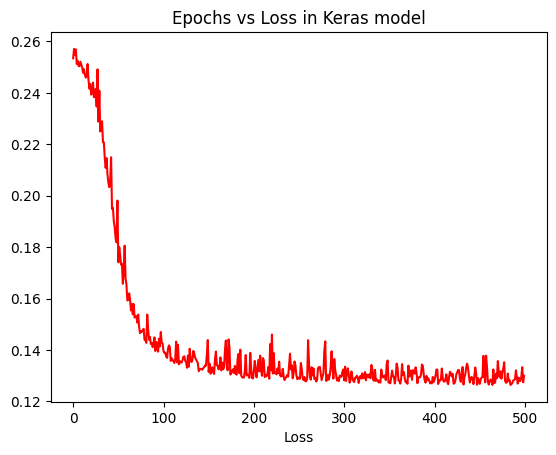

In [9]:

plt.plot(history_keras_model.history['loss'], 'red')
plt.title("Epochs vs Loss in Keras model")
plt.xlabel("Epochs")
plt.xlabel("Loss")

### V. Comparamos ambos modelos 

Text(0, 0.5, 'Loss')

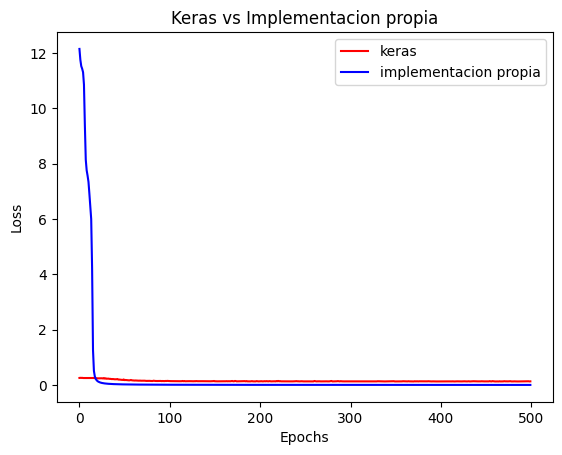

In [10]:


fig = plt.figure()
ax = fig.add_subplot()
line1 = ax.plot(history_keras_model.history['loss'], 'red')
line2 = ax.plot(history, 'blue')
ax.legend(np.array(['keras', 'implementacion propia']))

plt.title("Keras vs Implementacion propia")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [11]:




y_keras_model = keras_model.predict(X)
y_pred = model.predict(X)


3/3 [==============================] - 0s 5ms/step
